# Glutimate Puffing Experiments Data Pipeline

### Imports

In [1]:
import imganlys.ImagingPreProc as iPP
import imganlys.BehavPreProc as bPP
import os
from os.path import sep, exists
import tkinter as tk
from tkinter import filedialog

import numpy as np
import pandas as pd
import tifffile as tf
import napari
import cv2 as cv
import pickle
import re

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import transforms
import matplotlib.patheffects as PathEffects
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

In [69]:
def print_as_csv(stack):
    """ Given a 2d nparray, print the values as a csv"""
    for row in np.squeeze(stack):
        for col in row:
            val = col
            if type(col) == bool or type(col) == np.bool_:
                if col == False:
                    val = 0
                if col == True:
                    val = 1
                print(f"{val}", end=",")
            else:
                val = col
                print(f"{val:.3f}", end=",")
        print()

In [3]:
cmap = 'PiYG'

## Algorithm walkthrough

### Select trial to walk through examples with

In [4]:
### Load tiff files
root = tk.Tk()
root.withdraw()
root.attributes('-topmost',1)

trialfileNms = filedialog.askopenfilenames() ### Kerstin\20230119_6sss96-wtb\20230119_6s-ss96-wtb_brain2_r1.png
trial = trialfileNms[0]

In [5]:
print(trial)

# Load the stack
[stack, nCh, nDiscardFBFrames, fpv] = iPP.loadTif(trial)
print(f"stack shape: {stack.shape}")

Z:/2PImaging/Kerstin/20230119_HD7_wtb/tiffs/20230119_6s-ss96-wtb_brain2_r1.tif
stack shape: (1, 496, 2, 256, 128)


### Get the frame interval

In [6]:
# Get frame interval (time between frames)
with tf.TiffFile(trial) as tif:
    imagej_metadata = tif.imagej_metadata
    fm_interval = float(imagej_metadata.get("finterval"))
print(f"frame interval: {fm_interval} ms")

frame interval: 0.3638535747555555 ms


### Calculate the average z projection

In [7]:
frameidx = 1 # index of stack shape with frames
ch = 0 # channel to be used

# Select the first channel
# Stack axes [Z?, frame, channel, X, Y]
stack = stack[:,:,ch:ch+1,:,:]

### iPP.getROIs
mean_stack = stack.mean(axis=1) # Axis 0 is of length one so it just returns the whole stack

Its a bunch of numbers?!

In [58]:
print_as_csv(np.squeeze(mean_stack))

45.988,46.861,48.716,46.935,53.591,49.629,47.000,48.897,49.421,48.010,48.234,57.798,50.208,47.490,46.409,46.694,46.817,47.526,47.597,46.635,46.748,46.238,45.534,45.405,46.026,46.454,46.423,47.008,47.786,46.163,45.788,48.655,47.829,47.806,46.688,45.696,46.002,45.760,47.490,48.758,48.367,47.058,45.403,47.117,46.911,46.857,46.272,47.478,44.901,46.484,45.377,46.349,47.163,47.556,46.258,47.518,46.407,49.708,47.379,45.994,46.808,47.724,48.048,47.181,48.157,47.591,48.125,46.567,49.105,46.456,47.292,46.159,46.185,48.744,47.218,47.893,46.700,49.764,47.589,46.865,45.651,46.639,49.044,46.232,45.028,45.722,46.062,46.306,47.524,47.978,46.903,48.095,46.508,48.365,45.248,48.613,47.431,46.401,46.464,46.345,45.028,47.746,46.183,45.069,47.010,47.490,46.298,47.710,47.530,47.421,46.077,47.980,47.746,49.145,46.123,45.603,45.867,48.163,46.397,46.317,47.708,47.722,46.458,45.905,46.333,47.935,46.964,47.804,
45.962,46.935,47.433,47.849,51.038,49.198,48.615,49.700,51.159,48.286,47.304,47.815,45.385,45.569,45.52

### Plot it!

In [9]:
print(mean_stack.shape)

(1, 1, 256, 128)


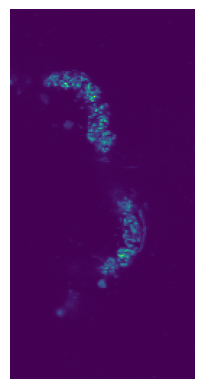

In [45]:
plt.imshow(np.squeeze(mean_stack),
           interpolation=None)
plt.axis('off');

In [46]:
plt.close()

### Draw an ROI

In [43]:
%%capture
# Load the mean image in napari
viewer = napari.Viewer()
viewer.add_image(mean_stack)
napari.run()

# Use the ROIs that were drawn in napari to get image masks
rois = viewer.layers['Shapes'].data

![Image](presentation\images\napari_draw_roi.png)

Its just a bunch of points?!

In [62]:
xidx = 2
yidx = 3
print_as_csv(rois[0][:,xidx:yidx+1])

93.322,56.851,
96.231,58.306,
99.763,59.137,
98.517,61.215,
99.971,63.084,
100.386,65.162,
98.932,67.448,
96.231,69.525,
94.153,69.941,
93.322,71.811,
90.621,72.018,
89.167,73.473,
86.258,73.265,
85.012,71.187,
83.557,68.486,
84.388,65.370,
85.219,63.916,
87.089,62.877,
88.336,61.630,
90.414,60.591,
91.245,58.098,
92.284,56.436,


### Plot it!

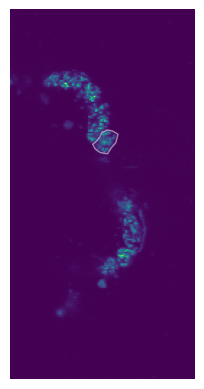

In [14]:
#Plot ROI
fig = plt.figure()
panel = plt.axes()

panel.imshow(np.squeeze(mean_stack),
             interpolation=None)
panel.axis('off')
for j,r in [(0,rois[0])]:
    
    panel.add_patch(Polygon([[pt[yidx],pt[xidx]] for pt in r], 
                            closed=True,fill=False, edgecolor = (1,1,1,0.5)))

In [15]:
plt.close(fig)

### Convert the roi to a mask

In [47]:
shape_x = stack.shape[3]
shape_y =  stack.shape[4]
all_masks = viewer.layers['Shapes'].to_masks(mask_shape=(shape_x,shape_y))

Its a bunch of 0s and 1s ?

In [68]:
print(type(all_masks[0][0][0]))

<class 'numpy.bool_'>


In [70]:
# print(np.squeeze(all_masks))
print_as_csv(np.squeeze(all_masks))

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Plot it!

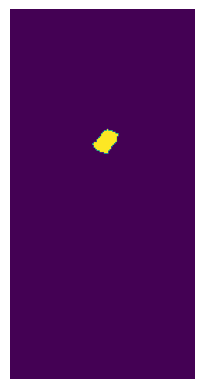

In [18]:
plt.axis('off')
plt.imshow(np.squeeze(all_masks),
           interpolation=None)

In [19]:
plt.close()

### Multiply the image with the mask
Just a fancy way to crop an image

In [20]:
cropped_mean = np.multiply(mean_stack, all_masks[0])
# print(cropped_mean.shape)
print_as_csv(cropped_mean)

0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

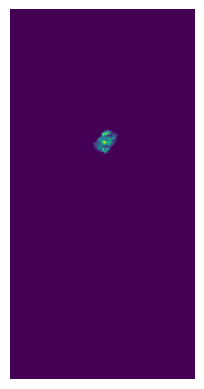

In [21]:

plt.axis('off')
plt.imshow(np.squeeze(cropped_mean),
           interpolation=None)

In [22]:
plt.close()

### Colorbar Function and other plotting params

In [23]:
def plot_colorbar(fig, cbaraxes, F_plot, F_lims, cbarlabel):
    """Plot the colorbar for the given F_plot"""
    # Plot colorbar
    cbar_ax = fig.add_axes(cbaraxes)
    cbar = fig.colorbar(F_plot,cax=cbar_ax)
    cbar.set_ticks(F_lims)
    if (F_lims[0] > 10**2) or (F_lims[1] > 10**2):
        F_lims_str = [f"{lim:g}" for lim in F_lims]
    else:
        F_lims_str = [f"{lim:.2f}" for lim in F_lims]
    cbar.ax.set_yticklabels(F_lims_str)
    cbar.set_label(cbarlabel, labelpad = -25)

In [24]:
figureWidth = 5
figureHeight = 3
panelWidth = 4
panelHeight = 1
spacing = 0.5

cbaraxes = [1.2*spacing+panelWidth/figureWidth,
            spacing,
            0.1/figureWidth,
            panelHeight/figureHeight]

### Calculate the Raw Florescence
Simply add up the pixel values in your cropped image to get the raw florescence

In [31]:
# Initialize the array to hold the fluorescence data
rawF = np.zeros((stack.shape[frameidx],len(all_masks)))

# Step through each frame in the stack
for fm in range(0,stack.shape[frameidx]):
    fmNow = stack[0,fm,ch,:,:]

    # Find the sum of the fluorescence in the ROI for the given frame
    rawF[fm,0] = np.multiply(fmNow, all_masks[0]).sum()


In [34]:
print("Florescence of first 10 frames:")
print(rawF[:10])

Florescence of first 10 frames:
[[46287.]
 [47469.]
 [51127.]
 [45468.]
 [48166.]
 [54758.]
 [50371.]
 [50205.]
 [52329.]
 [53880.]]


### Plot it!

[]

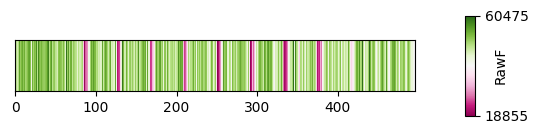

In [35]:
figure = plt.figure(figsize=(figureWidth, figureHeight))
panel = plt.axes([spacing, spacing,
                  panelWidth/figureWidth, panelHeight/figureHeight])

rawF_lims = [np.amin(rawF), np.amax(rawF)]
rawF_plot = panel.imshow(rawF.T,
             interpolation='Nearest', aspect=64, cmap=cmap,
             vmin=rawF_lims[0], vmax=rawF_lims[1])
plot_colorbar(figure, cbaraxes, rawF_plot, rawF_lims, cbarlabel="RawF")

panel.set_yticks([]) # Remove y ticks

In [36]:
plt.close(figure)

In [37]:
#TODO Show full plot of florescence

### Calculate the Change in Florescence over the baseline florenscence

Use the first 10 seconds of trial as baseline activity, since there is no puffing yet.

Then divide the raw florescence by the baseline.

In [38]:
# Initialize the array to hold the DF/F data
DF = np.zeros(rawF.shape)

# rawF axes: [frames, rois]
baseline_sec = 10
baseline_end_frame = round(baseline_sec / fm_interval)

# Calculate the DF/F for each ROI
for r in range(0,rawF.shape[1]):
    Fbaseline = rawF[0:baseline_end_frame, r].mean()
    DF[:,r] = rawF[:,r]/Fbaseline-1

In [39]:
print(f"Baseline florescence: {Fbaseline}")
print("Change in Florescence over baseline of first 10 frames:")
print(DF[:10])

Baseline florescence: 51003.333333333336
Change in Florescence over baseline of first 10 frames:
[[-0.09247108]
 [-0.06929612]
 [ 0.00242468]
 [-0.10852885]
 [-0.05563035]
 [ 0.0736161 ]
 [-0.01239788]
 [-0.01565257]
 [ 0.02599177]
 [ 0.05640154]]


### Plot it!

[]

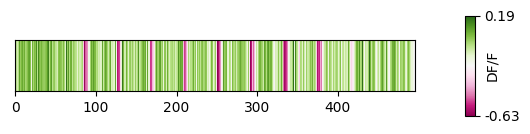

In [40]:
figure = plt.figure(figsize=(figureWidth, figureHeight))
panel = plt.axes([spacing, spacing,
                  panelWidth/figureWidth, panelHeight/figureHeight])

DF_lims = [np.amin(DF), np.amax(DF)]
DF_plot = panel.imshow(DF.T,
             interpolation='Nearest', aspect=64, cmap=cmap,
             vmin=DF_lims[0], vmax=DF_lims[1])
plot_colorbar(figure, cbaraxes, DF_plot, DF_lims, cbarlabel="DF/F")

panel.set_yticks([]) # Remove y ticks

In [41]:
plt.close(figure)

### Now do it for all glomeruli of the PB!

In [42]:
###TODO Add image of complete graph